# Model training

The model will now be trained with the processed images.

### Imports

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import keras
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import Sequence

'\ndef _is_distributed_dataset(ds):\n    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)\n\ndata_adapter._is_distributed_dataset = _is_distributed_dataset\n'

In [2]:
tf.__version__

'2.16.1'

### Split into train, validation and test images.

In [3]:
# Define paths
data_dir = '../data/processed'
labels_csv = '../data/processed/labels.csv'

# Load labels
labels_df = pd.read_csv(labels_csv)

# Extract labels and convert to list of sets for MultiLabelBinarizer
labels = []
for i in range(len(labels_df)):
    row_labels = labels_df.iloc[i, 1:].astype(int).tolist()
    active_labels = [label for label, active in zip(labels_df.columns[1:], row_labels) if active]
    labels.append(active_labels)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(labels)

# Split data paths and labels. Use 80% for training and 20% for testing
image_paths = labels_df['filename'].apply(lambda x: os.path.join(data_dir, x)).values
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)
# Split the remaining 20% equally into validation and test sets
X_val_paths, X_test_paths, y_val, y_test = train_test_split(X_temp_paths, y_temp, test_size=0.5, random_state=42)

class ImageDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(128, 128)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        for path in batch_paths:
            img = image.load_img(path, target_size=self.target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            images.append(img)
        
        return np.array(images), np.array(batch_labels)
    
    def on_epoch_end(self):
        pass

# Create data generators
batch_size = 32
train_generator = ImageDataGenerator(X_train_paths, y_train, batch_size=batch_size)
val_generator = ImageDataGenerator(X_val_paths, y_val, batch_size=batch_size)
test_generator = ImageDataGenerator(X_test_paths, y_test, batch_size=batch_size)

# Print the different labels in the dataset
print('Labels:', mlb.classes_)

# Print head of the labels dataframe
print(labels_df.head())

Labels: ['negative' 'original' 'red_tint' 'rotated_left' 'rotated_right'
 'upside_down']
                         filename  original  rotated_left  rotated_right  \
0       airplane_1_original_0.jpg         1             0              0   
1   airplane_1_rotated_left_0.jpg         0             1              0   
2  airplane_1_rotated_right_0.jpg         0             0              1   
3    airplane_1_upside_down_0.jpg         0             0              0   
4       airplane_1_negative_0.jpg         0             0              0   

   upside_down  negative  red_tint  
0            0         0         0  
1            0         0         0  
2            0         0         0  
3            1         0         0  
4            0         1         0  


Check some properties

In [4]:
# Print the number of samples in each dataset
print('Number of training samples:', len(X_train_paths))
print('Number of validation samples:', len(X_val_paths))
print('Number of testing samples:', len(X_test_paths))

Number of training samples: 13920
Number of validation samples: 1740
Number of testing samples: 1740


Visualize class distribution in training set

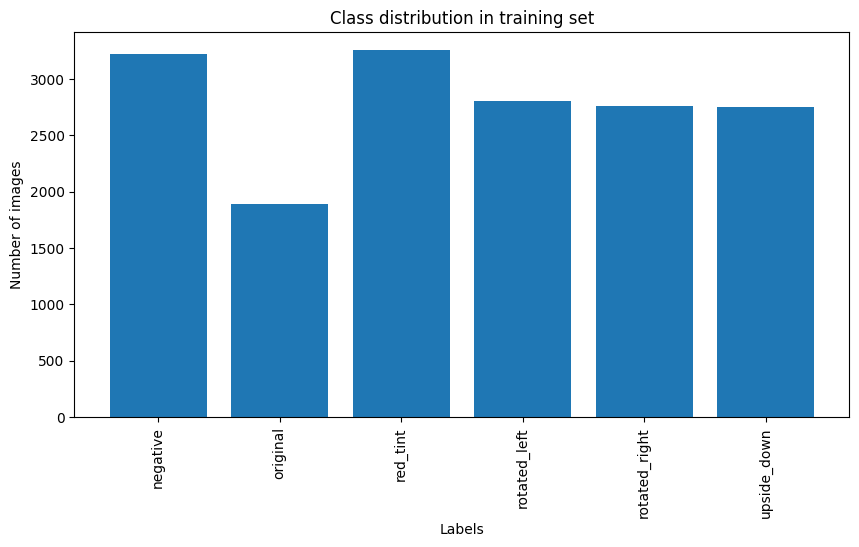

In [5]:
# Visualize class distribution in training set
plt.figure(figsize=(10, 5))
plt.bar(mlb.classes_, y_train.sum(axis=0))
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Number of images')
plt.title('Class distribution in training set')
plt.show()

### Create model

In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')  # Sigmoid for multi-label classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# summary
model.summary()

c:\Users\elias\OneDrive\Dokumente\ZHAW\6. Semester\Machine Learning II\Projekt\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,118 (1008.27 KB)

 Trainable params: 258,118 (1008.27 KB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [7]:
# Train model using generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Adjust the number of epochs as needed
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

Epoch 1/50


c:\Users\elias\OneDrive\Dokumente\ZHAW\6. Semester\Machine Learning II\Projekt\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


435/435 ━━━━━━━━━━━━━━━━━━━━ 416s 942ms/step - accuracy: 0.3943 - loss: 0.4451 - val_accuracy: 0.5203 - val_loss: 0.3797
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 316s 727ms/step - accuracy: 0.5027 - loss: 0.3804 - val_accuracy: 0.5289 - val_loss: 0.3632
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 330s 757ms/step - accuracy: 0.5269 - loss: 0.3622 - val_accuracy: 0.5226 - val_loss: 0.3590
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 325s 745ms/step - accuracy: 0.5349 - loss: 0.3554 - val_accuracy: 0.5579 - val_loss: 0.3529
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 279s 641ms/step - accuracy: 0.5480 - loss: 0.3512 - val_accuracy: 0.5874 - val_loss: 0.3471
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 326s 749ms/step - accuracy: 0.5689 - loss: 0.3458 - val_accuracy: 0.6146 - val_loss: 0.3309
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 336s 770ms/step - accuracy: 0.6044 - loss: 0.3371 - val_accuracy: 0.6678 - val_loss: 0.3180
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 314s 718ms/step - accuracy: 0.6445 - loss: 0.32

### Accuracy and loss

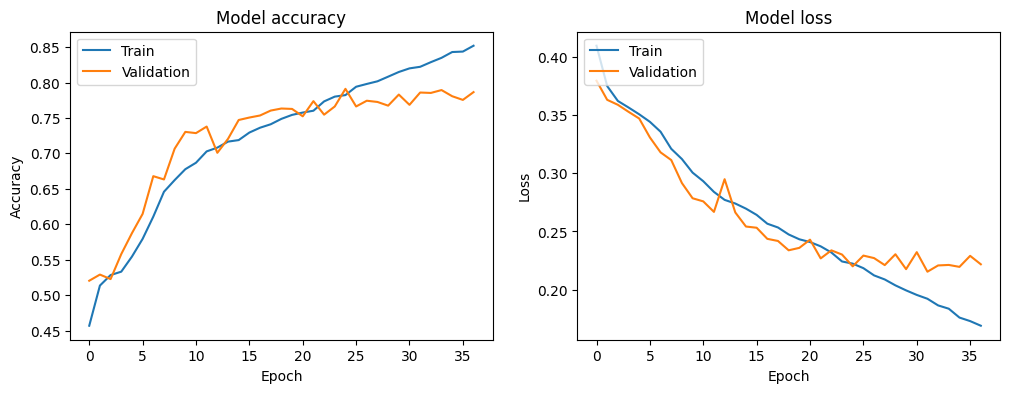

In [8]:
# Plot training & validation accuracy values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

![alt text](output.png)

The training loss consistently decreases, approaching 0.1702 towards the end. This decline shows that the model is reducing the error on the training set effectively. A smooth and continuous decrease in training loss signifies that the optimization process is functioning well, without abrupt changes that might indicate learning rate issues or instability.

The validation loss decreases initially and stabilizes around 0.25 after 20 epochs. The fact that it remains above the training loss indicates that there is some overfitting, but it is not severe. The validation loss curve shows some bumps, corresponding to the fluctuations in validation accuracy. This relationship highlights the model's varying performance on unseen data.

The steady improvement in training accuracy and loss suggests that the chosen learning rate and batch size are appropriate. However, experimenting with slightly lower learning rates or adaptive learning rate schedules could potentially smoothen the validation performance further.

A well-tuned batch size ensures efficient training while maintaining gradient stability. The current performance indicates that these parameters were likely set appropriately.

To improve generalisation, perhaps some data augmentation strategies could be employed. This approach would expose the model to a wider variety of training examples, reducing overfitting and improving validation performance.

Final Testing: A test accuracy of approximately 79.05% and a loss of 0.2269 further confirm the model's generalization capabilities. 

### Save model

In [9]:
# save model with an incremental number
model.save(f'../models/model_{len(os.listdir("../models"))}.h5')

### Interpretation and Validation

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
               precision    recall  f1-score   support

     negative       0.26      0.95      0.41       405
     original       0.68      0.10      0.17       215
     red_tint       0.94      0.22      0.36       415
 rotated_left       0.63      0.07      0.12       317
rotated_right       0.55      0.22      0.31       352
  upside_down       0.55      0.17      0.26       391

    micro avg       0.35      0.32      0.33      2095
    macro avg       0.60      0.29      0.27      2095
 weighted avg       0.60      0.32      0.29      2095
  samples avg       0.32      0.31      0.30      2095



c:\Users\elias\OneDrive\Dokumente\ZHAW\6. Semester\Machine Learning II\Projekt\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


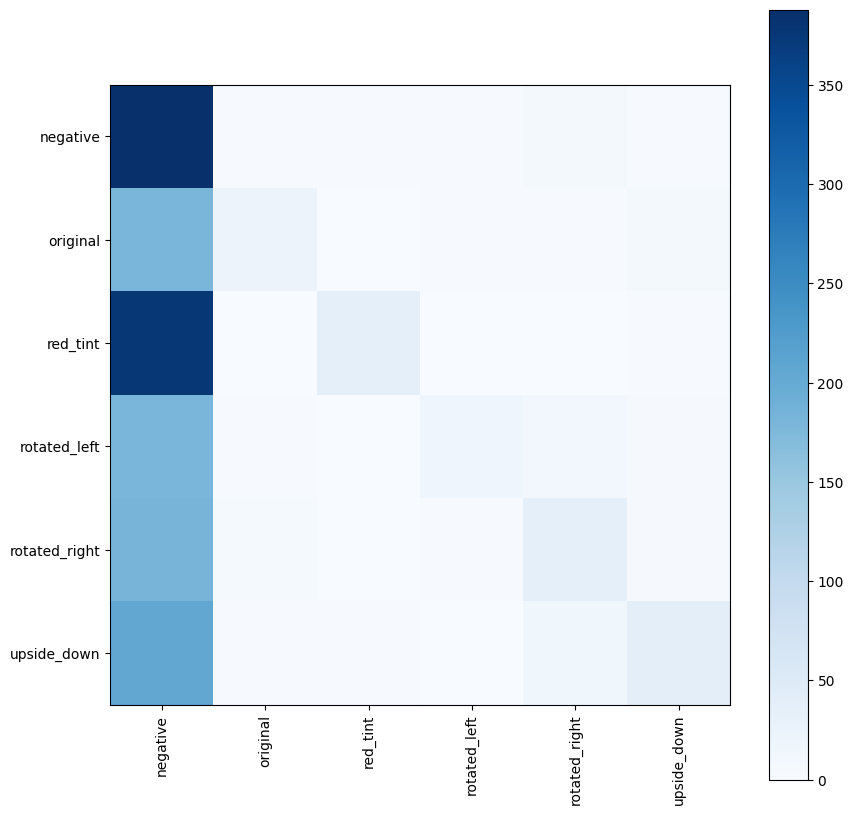

"\n# Load the model\nmodel = tf.keras.models.load_model('../models/model_0.h5')\n\n# Load an image\nimg_path = '../data/processed/0001.jpg'\n\n# Load and preprocess the image\nimg = image.load_img(img_path, target_size=(128, 128))\nimg_array = image.img_to_array(img)\nimg_array = img_array / 255.0\nimg_array = np.expand_dims(img_array, axis=0)\n\n# Make a prediction\nprediction = model.predict(img_array)\n\n# Print the prediction\nprint('Prediction:', mlb.classes_[prediction[0] > 0.5])\n"

In [21]:
# convert valdation data to numpy array
X_val = np.array([image.img_to_array(image.load_img(path, target_size=(128, 128))) for path in X_val_paths])
y_val = np.array(y_val)

# make predictions
y_pred = model.predict(X_val)

# print classification report
print(classification_report(y_val, y_pred > 0.5, target_names=mlb.classes_))

# plot confusion matrix
conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap='Blues')
plt.xticks(np.arange(6), mlb.classes_, rotation=90)
plt.yticks(np.arange(6), mlb.classes_)
plt.colorbar()
plt.show()

![alt text](image.png)

The performance of the model varies significantly between classes, as shown in the classification reports. For the "negative" class, the model achieves a high recall of 95%, but a low precision of 26%, indicating that many non-negative instances are misclassified as negative. This results in a moderate F1 score of 0.41. In contrast, the "original" class has a high precision of 68%, but a very low recall of 10%, meaning that the model rarely misclassifies instances as original, but misses many true original instances, resulting in a low F1 score of 0.17.

Similarly, the 'red_tint' class has a high precision of 94% but a low recall of 22%, resulting in an F1 score of 0.36. This suggests that the model is conservative in predicting this class, resulting in many false negatives. The class "rotated_left" shows a poor performance with a precision of 63% but a very low recall of 7%, indicating significant difficulties for the model to correctly identify this class, with an F1 score of 0.12.

For the "rotated_right" class, the model achieves a moderate precision of 55% and a recall of 22%, resulting in an F1 score of 0.31, indicating the difficulty in accurately identifying these instances. The "upside_down" class also shows a moderate precision of 55% and a low recall of 17%, resulting in an F1 score of 0.26. Overall, the model struggles to reliably recognise the transformed classes, highlighting the need for better data augmentation and model tuning.

For the "rotated_right" class, the model achieves a moderate precision of 55% and a recall of 22%, resulting in an F1 score of 0.31, indicating the difficulty in accurately identifying these instances. The "upside_down" class also shows a moderate precision of 55% and a low recall of 17%, resulting in an F1 score of 0.26. Overall, the model struggles to reliably recognise the transformed classes, highlighting the need for better data augmentation and model tuning.

![alt text](image-1.png)

The confusion matrix shows that most predictions fall into the "negative" category. This is evident from the dark blue vertical bar corresponding to "negative" in the predicted labels. The high recall and low precision for the "negative" class indicate that the model is overly sensitive to this class, possibly due to more distinctive features associated with the "negative" class that dominate the decision-making proces.

The lighter shades for other classes indicate poor recognition. Classes like "original", "red_tint", "rotated_left", "rotated_right" and "upside_down" have low prediction values. This could be due to insufficient or ineffective feature extraction for these classes. The model may not have learned to distinguish these transformations effectively.

The chosen model architecture might not be complex enough to capture the differences between classes or might require further tuning. Experimenting with deeper or more sophisticated architectures (e.g., convolutional neural networks with more layers or attention mechanisms) could improve feature extraction and classification accuracy.

For a similar project in the future, I would use multiple models instead of a single multi-class model. This approach would allow each model to specialise in recognising its specific class, reducing the impact of class imbalance and simplifying the learning task. Using a pre-trained model with fine-tuning might also have achieved better results.

### Final Test

The model should go through images from the additional test folder and recognise which transformations are present in each image. The images should then be corrected automatically. The result can then be checked by eye in the output folder. 

In [31]:
from PIL import Image, ImageOps, ImageEnhance

# Load the newest model
model_path = f'../models/model_{len(os.listdir("../models")) - 1}.h5'
model = tf.keras.models.load_model(model_path)

# Directories
additional_test_data_dir = "../data/additional_test_data"
corrected_dir = "../data/corrected"

# Create corrected directory if it doesn't exist
if not os.path.exists(corrected_dir):
    os.makedirs(corrected_dir)

# Image preprocessing function
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Correction functions
def correct_image(img, prediction):
    if prediction == 'negative':
        img = ImageOps.invert(img)
    elif prediction == 'rotated_left':
        img = img.rotate(-90, expand=True)
    elif prediction == 'rotated_right':
        img = img.rotate(90, expand=True)
    elif prediction == 'upside_down':
        img = img.rotate(180, expand=True)
    elif prediction == 'red_tint':
        # Correct red tint by adjusting the channels moderately
        r, g, b = img.split()
        r = r.point(lambda i: i * 0.7)  # Moderately reduce the intensity of the red channel
        g = g.point(lambda i: i * 1.2)  # Moderately increase the intensity of the green channel
        b = b.point(lambda i: i * 1.2)  # Moderately increase the intensity of the blue channel
        img = Image.merge('RGB', (r, g, b))
    return img

# Process and correct images
for img_name in os.listdir(additional_test_data_dir):
    img_path = os.path.join(additional_test_data_dir, img_name)
    try:
        img = Image.open(img_path)
        
        # Preprocess image
        img_array = preprocess_image(img_path)
        
        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)
        
        # Map predicted class index to class label
        classes = ['negative', 'original', 'red_tint', 'rotated_left', 'rotated_right', 'upside_down']
        predicted_label = classes[predicted_class[0]]
        
        # Correct the image if necessary
        if predicted_label != 'original':
            corrected_img = correct_image(img, predicted_label)
        else:
            corrected_img = img
        
        # Save the corrected image
        corrected_img.save(os.path.join(corrected_dir, img_name))
        print(f"Processed and saved: {img_name}")
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

print("Image correction completed and saved to the 'corrected' folder.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Processed and saved: 1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Processed and saved: 10.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processed and saved: 11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Processed and saved: 12.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Processed and saved: 13.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processed and saved: 14.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processed and saved: 15.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Processed and saved: 16.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Processed and saved: 17.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Processed and saved: 18.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Processed and saved: 19.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Processed and saved: 2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Processed and saved: 20.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Processed and saved: 21.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Processed and saved: 22.jpg
1/1 ━━━━━━

Unfortunately, the model does not work well in this test either and makes some mistakes. The images with a red tint are recognised and corrected most successfully.